# Credit Risk Analysis

## Projeto 1: Desenvolvimento de um modelo de concessão de crédito.

**Objetivo:** desenvolver um modelo de concessão de crédito (classificação binária) usando as bases `train.gz`, `test.gz` e `oot.gz`.

**Etapas:**
1. Entendimento da base e análise exploratória dos dados;
2. Pré-processamento das variáveis;
3. Treinamento de um modelo de classificação binária;
4. Análise técnica da performance do modelo, medida sobre a base de Teste.

## Dataset
A base contém 150 variáveis, a maioria das quais está mascarada. Utilize a coluna ID como uma key.

A variável alvo é denominada TARGET e possui os seguintes valores:

- 1: Mau Pagador, i.e. atraso > 60 dias em 2 meses.
- 0: Bom Pagador, i.e. caso contrário.
O score do modelo de classificação deve mapear a classe Bom Pagador.

A base de dados está contida na pasta ../datasets/credit_01 e é dividida em 3 partes:

* Treino: base usada para treinamento contendo dados de janeiro a agosto de 2017;

* Teste: base usada para testes contendo dados de janeiro a agosto de 2017;

* Out-of-time (oot): contém dados obtidos de setembro a novembro de 2017. A escoragem dessa base pode ser uma etapa do desafio, a depender das condições e requisitos combinados.

A base outoftime é considerada uma base "cega" por não possuir a variável "TARGET" (apenas a equipe do Prophet/Neurolake possui acesso a essa variável).

## Import libraries

In [1]:
# Data cleaning and wrangling
import pandas as pd
import numpy as np

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split # a base já vem separada em treino e test como arquivos diferentes

# Pré-processamento 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Modelos
from sklearn.linear_model import LinearRegression

# Manter saída do processamento do sklearn como DataFrame Pandas
from sklearn import set_config
set_config(transform_output='pandas')


## Import datasets

In [2]:
CREDIT_TRAIN = pd.read_csv('../../datasets/credit_01/train.gz', compression='gzip')
CREDIT_TEST = pd.read_csv('../../datasets/credit_01/test.gz', compression='gzip')
CREDIT_OOT = pd.read_csv('../../datasets/credit_01/oot.gz', compression='gzip')

df_train = CREDIT_TRAIN
df_test = CREDIT_TEST
df_oot = CREDIT_OOT

## Data understanding

In [3]:
df_train.head(3)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,181755
1,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,287633
2,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,88015


Ao que parece:
REF_DATE - Data
VAR2 - Sexo
VAR5 - Estado
VAR6 - Latitude
VAR7 - Longitude
VAR148 - Email

In [4]:
# Exibir informações (pd.options.display.max_info_columns)
df_train.info(verbose=True, memory_usage='deep', show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120750 entries, 0 to 120749
Data columns (total 151 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    REF_DATE  120750 non-null  object 
 1    TARGET    120750 non-null  int64  
 2    VAR2      106131 non-null  object 
 3    IDADE     107040 non-null  float64
 4    VAR4      202 non-null     object 
 5    VAR5      117394 non-null  object 
 6    VAR6      117394 non-null  float64
 7    VAR7      117394 non-null  float64
 8    VAR8      67640 non-null   object 
 9    VAR9      117447 non-null  object 
 10   VAR10     117474 non-null  object 
 11   VAR11     74488 non-null   float64
 12   VAR12     65724 non-null   float64
 13   VAR13     15530 non-null   float64
 14   VAR14     95197 non-null   float64
 15   VAR15     58269 non-null   float64
 16   VAR16     44981 non-null   float64
 17   VAR17     15530 non-null   float64
 18   VAR18     95197 non-null   float64
 19   VAR19     58269 non-n

In [5]:
# Variáveis com mais nulos
df_train.isna().sum().sort_values(ascending=False).head(25)

VAR146    120582
VAR4      120548
VAR46     120456
VAR45     120456
VAR44     120349
VAR43     120349
VAR145    120071
VAR38     119981
VAR26     119742
VAR27     119708
VAR143    119174
VAR144    119174
VAR31     116833
VAR48     112338
VAR33     112129
VAR34     112129
VAR20     109397
VAR28     108031
VAR30     108031
VAR17     105220
VAR13     105220
VAR23     105220
VAR21     105157
VAR29      96026
VAR37      95706
dtype: int64

In [6]:
# Variáveis com menos nulos
df_train.isna().sum().sort_values(ascending=False).tail(15)
# df_train.notna().sum().sort_values(ascending=False).head(30)



VAR136      2939
VAR132      2939
VAR131      2939
VAR137      2939
VAR138      2939
VAR142       165
VAR39         71
TARGET         0
REF_DATE       0
VAR47          0
VAR141         0
VAR147         0
VAR148         0
VAR149         0
ID             0
dtype: int64

Somente as variáveis TARGET, REF_DATE, VAR47, VAR141, VAR147, VAR148, VAR149 e ID não possuem nulos.

In [7]:
# Variáveis com apenas 1 valor (constante)
df_train.nunique().sort_values(ascending=False).tail(10)

VAR49     2
VAR48     2
VAR4      1
VAR36     1
VAR38     1
VAR33     1
VAR45     1
VAR43     1
VAR35     1
VAR149    1
dtype: int64

As variáveis VAR4, VAR33, VAR35, VAR36, VAR38, VAR43, VAR45, VAR149 possuem apenas 1 valor. 

In [8]:
# Análise descritiva das variáveis contínuas
df_train.describe()

,TARGET,IDADE,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,...,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147,ID
count,120750.000000,107040.000000,117394.000000,117394.000000,74488.000000,65724.000000,15530.000000,95197.000000,58269.000000,44981.000000,...,117811.000000,107048.000000,401.000000,294.000000,120750.000000,120750.000000,679.000000,168.000000,120750.000000,120750.000000
mean,0.245027,42.125255,-14.411389,-45.903480,0.235917,0.290241,0.313850,0.241245,0.185754,2.044374,...,0.631175,0.504619,1691.738429,6984.218469,0.256543,1854.833006,4018.743785,1942.649762,101.841656,165324.864199
std,0.430105,15.198476,8.995077,7.529788,0.625609,0.308937,0.241229,0.262687,0.195320,3.170869,...,0.222607,0.069614,2177.830516,4621.964093,0.406746,893.999792,3700.836248,3143.757850,0.540016,95488.442320
min,0.000000,18.014000,-33.521563,-72.900276,-4.000000,0.000000,0.000000,0.000000,0.000000,0.083333,...,0.000000,0.006658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,3.000000
25%,0.000000,30.057250,-22.842778,-49.903564,0.000000,0.055000,0.056000,0.105000,0.078000,0.250000,...,0.440572,0.463579,642.000000,3888.995000,0.000000,1513.227400,1633.195000,0.000000,102.000000,82727.250000
50%,0.000000,39.867000,-13.010590,-46.574908,0.000000,0.159000,0.318000,0.140000,0.112000,0.833333,...,0.542298,0.496036,769.000000,5386.310000,0.003000,1627.157652,3024.480000,935.120000,102.000000,165298.000000
75%,0.000000,52.997000,-6.357067,-39.023621,0.000000,0.505000,0.507000,0.168000,0.153000,2.416667,...,0.898052,0.522576,1747.500000,9601.390000,0.421000,1820.670284,5217.670000,2260.125000,102.000000,248248.000000
max,1.000000,105.477000,4.602823,-32.429516,4.000000,1.500000,1.000000,1.700000,1.000000,15.999999,...,1.000000,0.910865,17374.940000,26523.920000,1.000000,33954.140000,33954.140000,17229.200000,102.000000,330581.000000


A VAR11 vai de -4 a 4; e a VAR147 apresenta na sua maioria o valor 102.

In [9]:
# Identificando categorias das colunas

categ_cols = df_train[['VAR11', 'VAR147']]

categ_per_column = {
    col: categ_cols[col].unique()
    for col in categ_cols.columns if categ_cols[col].nunique() >= 1 # filtrando por 3 ou mais categorias
}

# Exibindo as categorias
print("Categorias por coluna:")
for col, categories in categ_per_column.items():
    print(f"{col}: {list(categories)}")

Categorias por coluna:
VAR11: [np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(3.0), np.float64(2.0), np.float64(4.0), np.float64(-1.0), np.float64(-2.0), np.float64(-3.0), np.float64(-4.0)]
VAR147: [np.int64(102), np.int64(100)]


A VAR11 tem 9 valores e a VAR147 tem 2.

<Axes: xlabel='IDADE', ylabel='Count'>

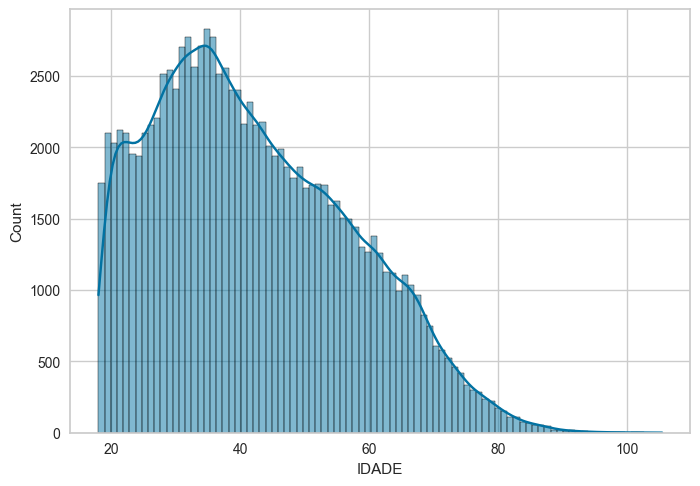

In [10]:
# Distribuição da idade
sns.histplot(df_train, x='IDADE', kde=True)

Grupo composto por pessoas com:
- Média de Idade: 42.12
- Mediana de Idade: 39.86



In [11]:
# Quantidade de casos de Target por Estado
df_train.groupby(by=['VAR5'])[['TARGET']].count()

,TARGET
VAR5,
AC,2304
AL,2800
AM,4145
AP,1292
BA,10306
CE,8262
DF,790
ES,2765
GO,2369


In [12]:
# Verificar os valores de TARGET por estado

if "VAR5" in df_train.columns and "TARGET" in df_train.columns:
    # Verificar valores únicos na coluna 'Estado' (opcional, para validação)
    print("Estados disponíveis:", df_train["VAR5"].unique())

    # Agregar os dados
    agregacao = df_train.groupby("VAR5")["TARGET"].value_counts().unstack(fill_value=0) # unstack preenche os estados sem registros específicos com 0

    # Renomear as colunas para clareza
    agregacao.columns = ["TARGET_0", "TARGET_1"]

    # Adicionar uma coluna com o total de observações por estado
    agregacao["Total"] = agregacao["TARGET_0"] + agregacao["TARGET_1"]
    
    # Calcular percentuais
    agregacao["Percentual_TARGET_0"] = (agregacao["TARGET_0"] / agregacao["Total"] * 100).round(2)
    agregacao["Percentual_TARGET_1"] = (agregacao["TARGET_1"] / agregacao["Total"] * 100).round(2)

    # Exibir o DataFrame resultante
    print(agregacao.sort_values(by='Percentual_TARGET_0', ascending=False))
    

Estados disponíveis: ['RO' 'PB' 'RS' 'BA' 'SP' 'MG' 'RJ' 'MS' 'PR' 'SC' 'RN' nan 'CE' 'AC' 'PE'
 'TO' 'AL' 'MT' 'ES' 'MA' 'AM' 'PI' 'DF' 'GO' 'PA' 'SE' 'RR' 'AP']
      TARGET_0  TARGET_1  Total  Percentual_TARGET_0  Percentual_TARGET_1
VAR5                                                                     
SC        1618       395   2013                80.38                19.62
MS        2014       501   2515                80.08                19.92
AC        1844       460   2304                80.03                19.97
MT        1609       406   2015                79.85                20.15
RO        1380       351   1731                79.72                20.28
PR        2907       761   3668                79.25                20.75
MG        6061      1696   7757                78.14                21.86
PI        1447       411   1858                77.88                22.12
RS        6544      1866   8410                77.81                22.19
TO         594       17

Top 3 estados com **mais registros:**
1. SP
2. BA
3. PA
   
Top 3 estados com maior percentual de **melhor pagador:**
1. SC
2. MS
3. AC

Top 3 estados com maior percentual de **pior pagador** (gráfico abaixo):
1. AP
2. AL
3. RR



<Axes: xlabel='VAR5', ylabel='TARGET'>

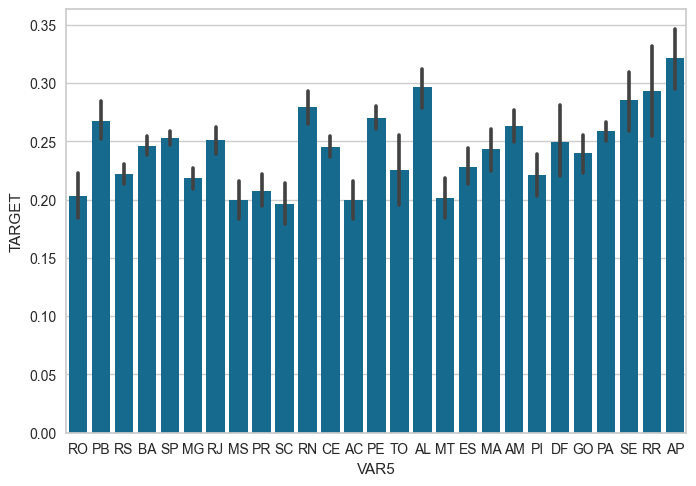

In [13]:
sns.barplot(df_train, x='VAR5', y='TARGET',)

In [14]:
df_train.groupby(by=['VAR2'])[['TARGET']].count()

,TARGET
VAR2,
F,60131
M,46000


In [15]:
# Verificar os valores de TARGET por estado

if "VAR2" in df_train.columns and "TARGET" in df_train.columns:
    # Verificar valores únicos na coluna 'Estado' (opcional, para validação)
    print("Sexo disponíveis:", df_train["VAR2"].unique())

    # Agregar os dados
    agrega = df_train.groupby("VAR2")["TARGET"].value_counts().unstack(fill_value=0) # unstack preenche os estados sem registros específicos com 0

    # Renomear as colunas para clareza
    agrega.columns = ["TARGET_0", "TARGET_1"]

    # Adicionar uma coluna com o total de observações por estado
    agrega["Total"] = agrega["TARGET_0"] + agrega["TARGET_1"]
    
    # Calcular percentuais
    agrega["Percentual_TARGET_0"] = (agrega["TARGET_0"] / agrega["Total"] * 100).round(2)
    agrega["Percentual_TARGET_1"] = (agrega["TARGET_1"] / agrega["Total"] * 100).round(2)

    # Exibir o DataFrame resultante
    print(agrega.sort_values(by='Total', ascending=False))

Sexo disponíveis: ['M' 'F' nan]
      TARGET_0  TARGET_1  Total  Percentual_TARGET_0  Percentual_TARGET_1
VAR2                                                                     
F        47360     12771  60131                78.76                21.24
M        33669     12331  46000                73.19                26.81


A maioria dos clientes são do sexo feminino, que também tem maior percentual de bom pagador.

<Axes: xlabel='VAR2', ylabel='TARGET'>

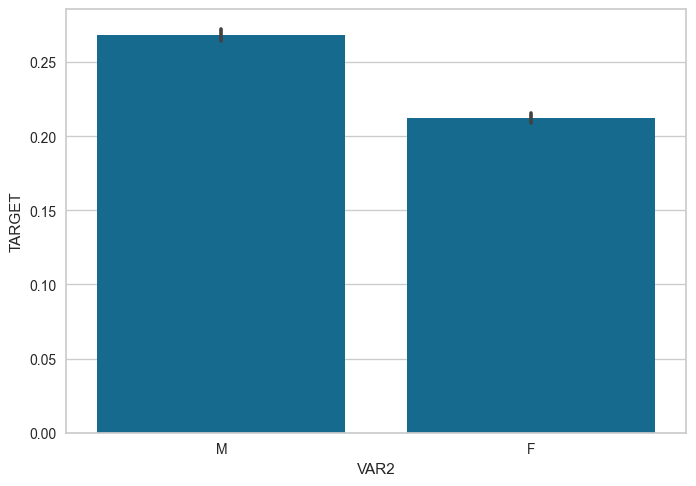

In [16]:
sns.barplot(df_train, x='VAR2', y='TARGET')

<Axes: xlabel='TARGET', ylabel='ID'>

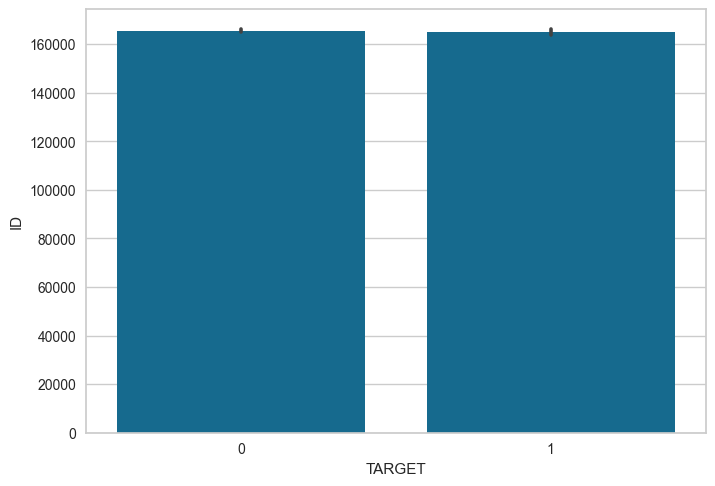

In [17]:
# Quantidade de casos de bom e mau pagador
sns.barplot(df_train, x='TARGET', y='ID')

## Data preparation

In [18]:
# Set ID as index

df = df_train.set_index('ID')
df.head()


,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,MUITO PROXIMO,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,120750.0,0.245027,0.430105,0.000000,0.000000,0.000000,0.000000,1.000000
IDADE,107040.0,42.125255,15.198476,18.014000,30.057250,39.867000,52.997000,105.477000
VAR6,117394.0,-14.411389,8.995077,-33.521563,-22.842778,-13.010590,-6.357067,4.602823
VAR7,117394.0,-45.903480,7.529788,-72.900276,-49.903564,-46.574908,-39.023621,-32.429516
VAR11,74488.0,0.235917,0.625609,-4.000000,0.000000,0.000000,0.000000,4.000000
VAR12,65724.0,0.290241,0.308937,0.000000,0.055000,0.159000,0.505000,1.500000
VAR13,15530.0,0.313850,0.241229,0.000000,0.056000,0.318000,0.507000,1.000000
VAR14,95197.0,0.241245,0.262687,0.000000,0.105000,0.140000,0.168000,1.700000
VAR15,58269.0,0.185754,0.195320,0.000000,0.078000,0.112000,0.153000,1.000000
VAR16,44981.0,2.044374,3.170869,0.083333,0.250000,0.833333,2.416667,15.999999


In [20]:
# Remoção de dados duplicados
df.drop_duplicates()

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,MUITO PROXIMO,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,2017-03-07 00:00:00+00:00,0,M,30.474,NaN,BA,-12.900183,-38.673056,E,E,...,MUITO LONGE,1752.116912,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
315754,2017-07-27 00:00:00+00:00,0,F,19.570,NaN,SP,-22.172110,-47.374184,E,E,...,LONGE,1510.234174,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1
156370,2017-05-04 00:00:00+00:00,0,M,32.882,NaN,SP,-22.327290,-49.033763,NaN,E,...,LONGE,1736.106081,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1


Após a remoção de linhas duplicadas restaram 120575.

### Date Format 

In [21]:
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])

# df['REF_DATE'] = df['REF_DATE'].dt.strftime('%Y-%m-%d')


In [22]:
df.dtypes

REF_DATE    datetime64[ns, UTC]
TARGET                    int64
VAR2                     object
IDADE                   float64
VAR4                     object
                   ...         
VAR145                  float64
VAR146                  float64
VAR147                    int64
VAR148                   object
VAR149                   object
Length: 150, dtype: object

In [23]:
df.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,...,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,NaN,RO,-8.808779,-63.878470,D,E,...,LONGE,2680.289259,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,NaN,PB,-7.146537,-34.926080,E,E,...,MUITO LONGE,1777.725469,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,NaN,RS,-27.900178,-53.314035,NaN,E,...,MUITO PROXIMO,1695.494979,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,NaN,BA,-12.948874,-38.451863,E,E,...,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,NaN,RS,-30.051810,-51.213277,B,E,...,MUITO PROXIMO,7868.793296,C,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1


### Missing values

In [22]:
# Calcular percentual de nulos por coluna
# (df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

# Calculo do percentual de valores nulos por coluna
perc_nulos = df.isnull().mean() * 100

# Exibição do resultado
print(perc_nulos.sort_values(ascending=False).head(35))

VAR146    99.860870
VAR4      99.832712
VAR46     99.756522
VAR45     99.756522
VAR43     99.667909
VAR44     99.667909
VAR145    99.437681
VAR38     99.363147
VAR26     99.165217
VAR27     99.137060
VAR143    98.694824
VAR144    98.694824
VAR31     96.756108
VAR48     93.033540
VAR33     92.860455
VAR34     92.860455
VAR20     90.597930
VAR30     89.466667
VAR28     89.466667
VAR13     87.138716
VAR23     87.138716
VAR17     87.138716
VAR21     87.086542
VAR29     79.524638
VAR36     79.259627
VAR37     79.259627
VAR35     78.388406
VAR32     65.174327
VAR16     62.748654
VAR25     51.744099
VAR19     51.744099
VAR15     51.744099
VAR22     51.694410
VAR12     45.570186
VAR8      43.983437
dtype: float64


33 variávies possuem mais de 50% de dados nulos

### Tratamento de nulos

#### Dataset com 50% dos nulos removidos

In [ ]:
# Remoção de colunas com mais de 50% de nulos

null_prop = df.isnull().mean()
remove_col = null_prop[null_prop > 0.5].index
df_train_drop_half = df.drop(columns=remove_col)

print(df_train_drop_half.info(verbose=True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 117 columns):
 #    Column    Non-Null Count   Dtype              
---   ------    --------------   -----              
 0    REF_DATE  120750 non-null  datetime64[ns, UTC]
 1    TARGET    120750 non-null  int64              
 2    VAR2      106131 non-null  object             
 3    IDADE     107040 non-null  float64            
 4    VAR5      117394 non-null  object             
 5    VAR6      117394 non-null  float64            
 6    VAR7      117394 non-null  float64            
 7    VAR8      67640 non-null   object             
 8    VAR9      117447 non-null  object             
 9    VAR10     117474 non-null  object             
 10   VAR11     74488 non-null   float64            
 11   VAR12     65724 non-null   float64            
 12   VAR14     95197 non-null   float64            
 13   VAR18     95197 non-null   float64            
 14   VAR24     97285 non-null   float64

Após a remoção de colunas com mais de 50% de valores nulos, restaram 117 colunas.

In [ ]:
df_train_drop_half.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,...,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,RO,-8.808779,-63.878470,D,E,BAIXA,...,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,M,40.447,PB,-7.146537,-34.926080,E,E,MEDIA,...,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,F,33.515,RS,-27.900178,-53.314035,NaN,E,ALTISSIMA,...,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,F,25.797,BA,-12.948874,-38.451863,E,E,MEDIA,...,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,F,54.074,RS,-30.051810,-51.213277,B,E,MEDIA,...,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102,EMAIL INEXISTENTE,2.6.1


In [ ]:
df_train_drop_half.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 117 columns):
 #    Column    Non-Null Count   Dtype              
---   ------    --------------   -----              
 0    REF_DATE  120750 non-null  datetime64[ns, UTC]
 1    TARGET    120750 non-null  int64              
 2    VAR2      106131 non-null  object             
 3    IDADE     107040 non-null  float64            
 4    VAR5      117394 non-null  object             
 5    VAR6      117394 non-null  float64            
 6    VAR7      117394 non-null  float64            
 7    VAR8      67640 non-null   object             
 8    VAR9      117447 non-null  object             
 9    VAR10     117474 non-null  object             
 10   VAR11     74488 non-null   float64            
 11   VAR12     65724 non-null   float64            
 12   VAR14     95197 non-null   float64            
 13   VAR18     95197 non-null   float64            
 14   VAR24     97285 non-null   float64

In [ ]:
df_train_drop_half[['VAR11','VAR93', 'VAR9']].nunique()

VAR11    9
VAR93    3
VAR9     5
dtype: int64

In [ ]:
df_train_drop_half.nunique().sort_values(ascending=True).head(50)

VAR149    1
TARGET    2
VAR55     2
VAR2      2
VAR60     2
VAR59     2
VAR58     2
VAR56     2
VAR53     2
VAR54     2
VAR51     2
VAR52     2
VAR49     2
VAR50     2
VAR62     2
VAR57     2
VAR64     2
VAR63     2
VAR90     2
VAR65     2
VAR120    2
VAR147    2
VAR100    2
VAR61     2
VAR67     3
VAR82     3
VAR93     3
VAR95     3
VAR68     4
VAR66     4
VAR70     4
VAR69     4
VAR89     4
VAR85     4
VAR79     4
VAR77     4
VAR80     4
VAR83     4
VAR84     4
VAR78     4
VAR86     4
VAR98     4
VAR74     4
VAR75     4
VAR73     4
VAR72     4
VAR76     4
VAR92     4
VAR97     4
VAR101    4
dtype: int64

In [ ]:
# Remoção de variáveis pouco explicativas: latitude, longitude, email e um código com um único valor
df_train_drop_half = df_train_drop_half.drop(columns=['VAR148', 'VAR149','VAR6', 'VAR7' ])
df_train_drop_half

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR8,VAR9,VAR10,VAR11,VAR12,...,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,M,34.137,RO,D,E,BAIXA,1.0,0.182,...,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102
287633,2017-08-18 00:00:00+00:00,0,M,40.447,PB,E,E,MEDIA,0.0,NaN,...,MEDIO,PROXIMO,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102
88015,2017-06-30 00:00:00+00:00,0,F,33.515,RS,NaN,E,ALTISSIMA,NaN,0.095,...,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102
122576,2017-08-05 00:00:00+00:00,1,F,25.797,BA,E,E,MEDIA,0.0,0.359,...,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102
1272,2017-07-29 00:00:00+00:00,0,F,54.074,RS,B,E,MEDIA,3.0,0.736,...,PROXIMO,MUITO PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,2017-03-07 00:00:00+00:00,0,M,30.474,BA,E,E,ALTISSIMA,0.0,0.714,...,MUITO LONGE,LONGE,MEDIO,LONGE,LONGE,MUITO LONGE,MUITO LONGE,1752.116912,E,102
315754,2017-07-27 00:00:00+00:00,0,F,19.570,SP,E,E,MEDIA,0.0,NaN,...,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,1510.234174,E,102
156370,2017-05-04 00:00:00+00:00,0,M,32.882,SP,NaN,E,MEDIA,NaN,0.659,...,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,1736.106081,E,102


In [ ]:
# Seleciona apenas as colunas categóricas
colunas_categoricas  = df_train_drop_half.select_dtypes(include='object')

# Filtra as colunas categóricas com número de categorias entre 3 e 5
colunas_filtradas = [
    coluna for coluna in colunas_categoricas 
    if 3 <= df_train_drop_half[coluna].nunique() <= 5
]

# Exibe as colunas filtradas
print("Variáveis categóricas com entre 3 e 5 categorias:")
print(colunas_filtradas)

# DataFrame com apenas as colunas filtradas
df_filtrado = df_train_drop_half[colunas_filtradas]

# Exibe informações do DataFrame filtrado
print(df_filtrado.info())


Variáveis categóricas com entre 3 e 5 categorias:
['VAR8', 'VAR9', 'VAR10', 'VAR66', 'VAR67', 'VAR68', 'VAR69', 'VAR70', 'VAR71', 'VAR72', 'VAR73', 'VAR74', 'VAR75', 'VAR76', 'VAR77', 'VAR78', 'VAR79', 'VAR80', 'VAR81', 'VAR82', 'VAR83', 'VAR84', 'VAR85', 'VAR86', 'VAR87', 'VAR88', 'VAR89', 'VAR91', 'VAR92', 'VAR93', 'VAR94', 'VAR95', 'VAR96', 'VAR97', 'VAR98', 'VAR99', 'VAR101', 'VAR102', 'VAR103', 'VAR104', 'VAR105', 'VAR106', 'VAR107', 'VAR108', 'VAR109', 'VAR110', 'VAR111', 'VAR112', 'VAR113', 'VAR114', 'VAR115', 'VAR116', 'VAR117', 'VAR118', 'VAR119', 'VAR121', 'VAR122', 'VAR123', 'VAR124', 'VAR125', 'VAR126', 'VAR127', 'VAR128', 'VAR129', 'VAR130', 'VAR131', 'VAR132', 'VAR133', 'VAR134', 'VAR135', 'VAR136', 'VAR137', 'VAR138', 'VAR139', 'VAR140', 'VAR142']
<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 76 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   VAR8    67640 non-null   object
 1   

- 21 variáveis com 2 categorias;
- 4 variáveis com 3 categorias;
- 76 variáveis categóricas com 3 a 5 categorias.

In [ ]:
# variáveis com 4 categorias
df_train_drop_half[['VAR67', 'VAR82', 'VAR93', 'VAR95']]

,VAR67,VAR82,VAR93,VAR95
ID,,,,
181755,BAIXISSIMA,ALTA,BAIXISSIMA,BAIXISSIMA
287633,ALTISSIMA,ALTA,ALTA,ALTA
88015,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA
122576,ALTA,ALTISSIMA,ALTISSIMA,ALTA
1272,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA
...,...,...,...,...
163230,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA
315754,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA
156370,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA


In [ ]:
# Identificando categorias das colunas

categorical_cols = df_train_drop_half[['VAR9','VAR67', 'VAR82', 'VAR93', 'VAR95', 'VAR121', 'VAR142']]

categories_per_column = {
    col: categorical_cols[col].unique()
    for col in categorical_cols.columns if categorical_cols[col].nunique() >= 3 # filtrando por 3 ou mais categorias
}

# Exibindo as categorias
print("Categorias por coluna:")
for col, categories in categories_per_column.items():
    print(f"{col}: {list(categories)}")

Categorias por coluna:
VAR11: [np.float64(1.0), np.float64(0.0), np.float64(nan), np.float64(3.0), np.float64(2.0), np.float64(4.0), np.float64(-1.0), np.float64(-2.0), np.float64(-3.0), np.float64(-4.0)]
VAR9: ['E', nan, 'D', 'C', 'B', 'A']
VAR67: ['BAIXISSIMA', 'ALTISSIMA', 'ALTA', nan]
VAR82: ['ALTA', 'BAIXISSIMA', 'ALTISSIMA', nan]
VAR93: ['BAIXISSIMA', 'ALTA', 'ALTISSIMA', nan]
VAR121: ['MUITO LONGE', 'MEDIO', 'PROXIMO', 'LONGE', nan]
VAR142: ['D', 'E', 'C', 'A', nan, 'B']


#### Dataset com 10% dos nulos removidos

In [24]:
# Remoção de colunas com mais de 10% de nulos

null_prop = df.isnull().mean()
remove_col = null_prop[null_prop > 0.1].index
df_train_drop_ten = df.drop(columns=remove_col)

print(df_train_drop_ten.info(verbose=True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 91 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  120750 non-null  datetime64[ns, UTC]
 1   TARGET    120750 non-null  int64              
 2   VAR5      117394 non-null  object             
 3   VAR6      117394 non-null  float64            
 4   VAR7      117394 non-null  float64            
 5   VAR9      117447 non-null  object             
 6   VAR10     117474 non-null  object             
 7   VAR39     120679 non-null  float64            
 8   VAR40     117466 non-null  float64            
 9   VAR41     117811 non-null  float64            
 10  VAR47     120750 non-null  float64            
 11  VAR66     117811 non-null  object             
 12  VAR67     117811 non-null  object             
 13  VAR68     117811 non-null  object             
 14  VAR69     117811 non-null  object             
 15  

Após a remoção de colunas com 10% de nulos restaram 91 colunas.

In [25]:
df_train_drop_ten.head()

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,RO,-8.808779,-63.878470,E,BAIXA,0.512334,0.486768,0.357526,...,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,PB,-7.146537,-34.926080,E,MEDIA,0.328021,0.447454,0.414335,...,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,RS,-27.900178,-53.314035,E,ALTISSIMA,0.627262,0.730539,0.916771,...,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,BA,-12.948874,-38.451863,E,MEDIA,0.338643,0.405233,0.408007,...,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,RS,-30.051810,-51.213277,E,MEDIA,0.626047,0.770664,0.907036,...,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102,EMAIL INEXISTENTE,2.6.1


In [26]:
df_train_drop_ten.describe().T

,count,mean,std,min,25%,50%,75%,max
TARGET,120750.0,0.245027,0.430105,0.000000,0.000000,0.000000,0.000000,1.000000
VAR6,117394.0,-14.411389,8.995077,-33.521563,-22.842778,-13.010590,-6.357067,4.602823
VAR7,117394.0,-45.903480,7.529788,-72.900276,-49.903564,-46.574908,-39.023621,-32.429516
VAR39,120679.0,0.461353,0.144093,0.049309,0.363787,0.462267,0.558495,0.953539
VAR40,117466.0,0.531287,0.115968,0.208688,0.447559,0.510023,0.582701,0.920685
VAR41,117811.0,0.631175,0.222607,0.000000,0.440572,0.542298,0.898052,1.000000
VAR47,120750.0,0.256543,0.406746,0.000000,0.000000,0.003000,0.421000,1.000000
VAR141,120750.0,1854.833006,893.999792,0.000000,1513.227400,1627.157652,1820.670284,33954.140000
VAR147,120750.0,101.841656,0.540016,100.000000,102.000000,102.000000,102.000000,102.000000


In [27]:
df_train_drop_ten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120750 entries, 181755 to 187156
Data columns (total 91 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  120750 non-null  datetime64[ns, UTC]
 1   TARGET    120750 non-null  int64              
 2   VAR5      117394 non-null  object             
 3   VAR6      117394 non-null  float64            
 4   VAR7      117394 non-null  float64            
 5   VAR9      117447 non-null  object             
 6   VAR10     117474 non-null  object             
 7   VAR39     120679 non-null  float64            
 8   VAR40     117466 non-null  float64            
 9   VAR41     117811 non-null  float64            
 10  VAR47     120750 non-null  float64            
 11  VAR66     117811 non-null  object             
 12  VAR67     117811 non-null  object             
 13  VAR68     117811 non-null  object             
 14  VAR69     117811 non-null  object             
 15  

In [28]:
df_train_drop_ten = df_train_drop_ten.drop_duplicates()

In [29]:
df_train_drop_ten.shape

(120449, 91)

#### Dataset com todos os nulos removidos

Conjunto gerado da remoção de valores nulos por linhas a partir do dataset de remoção de colunas com mais de 10% de nulos.

In [ ]:
# Eliminando valores nulos por linhas a partir do df_train_drop_ten

df_train_dropna = df_train_drop_ten.dropna()
df_train_dropna

,REF_DATE,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,...,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149
ID,,,,,,,,,,,,,,,,,,,,,
181755,2017-06-01 00:00:00+00:00,0,RO,-8.808779,-63.878470,E,BAIXA,0.512334,0.486768,0.357526,...,MUITO LONGE,LONGE,LONGE,MEDIO,LONGE,2680.289259,D,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
287633,2017-08-18 00:00:00+00:00,0,PB,-7.146537,-34.926080,E,MEDIA,0.328021,0.447454,0.414335,...,PROXIMO,LONGE,LONGE,LONGE,MUITO LONGE,1777.725469,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
88015,2017-06-30 00:00:00+00:00,0,RS,-27.900178,-53.314035,E,ALTISSIMA,0.627262,0.730539,0.916771,...,LONGE,LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,1695.494979,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
122576,2017-08-05 00:00:00+00:00,1,BA,-12.948874,-38.451863,E,MEDIA,0.338643,0.405233,0.408007,...,PROXIMO,MEDIO,LONGE,MEDIO,MEDIO,1399.037809,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
1272,2017-07-29 00:00:00+00:00,0,RS,-30.051810,-51.213277,E,MEDIA,0.626047,0.770664,0.907036,...,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO PROXIMO,7868.793296,C,102,EMAIL INEXISTENTE,2.6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163230,2017-03-07 00:00:00+00:00,0,BA,-12.900183,-38.673056,E,ALTISSIMA,0.292768,0.509101,0.771178,...,MEDIO,LONGE,LONGE,MUITO LONGE,MUITO LONGE,1752.116912,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1
315754,2017-07-27 00:00:00+00:00,0,SP,-22.172110,-47.374184,E,MEDIA,0.626240,0.423891,0.433104,...,LONGE,MEDIO,MEDIO,MEDIO,LONGE,1510.234174,E,102,EMAIL INEXISTENTE,2.6.1
156370,2017-05-04 00:00:00+00:00,0,SP,-22.327290,-49.033763,E,MEDIA,0.337504,0.484162,0.467808,...,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,1736.106081,E,102,EMAIL INEXISTENTE,2.6.1


Decidi seguir o dataset com até 10% de nulos por coluna porque removendo todos os nulos eu poderia perder informações relevantes das variáveis como a forma das categorias.

### Outliers

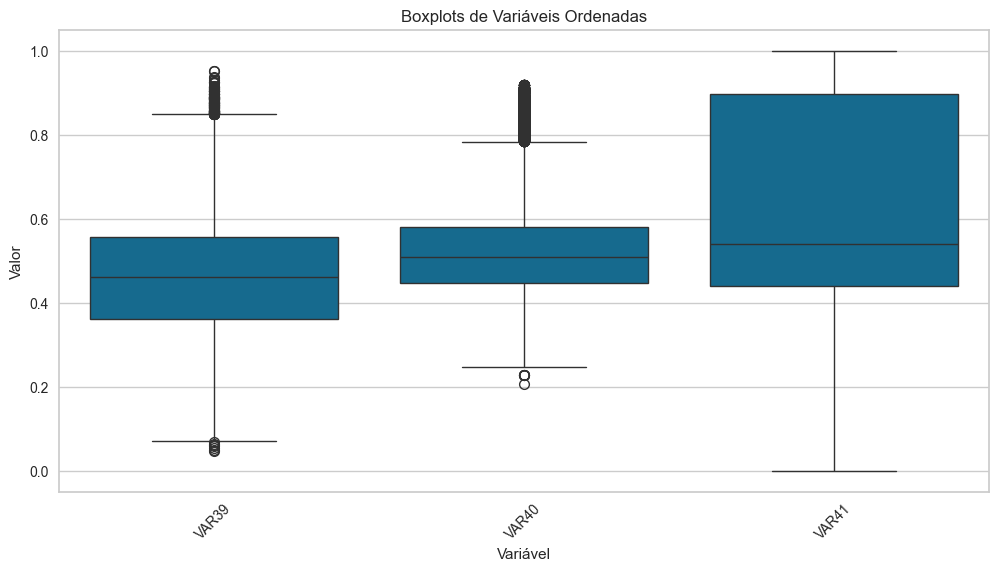

In [55]:
# Selecionando as variáveis desejadas na ordem correta do dataset df_train_drop_ten
variaveis_desejadas = ["VAR39", "VAR40", "VAR41"]
df_selecionado = df_train_drop_ten[variaveis_desejadas]

# Convertendo para o formato longo
df_long = df_selecionado.melt(var_name="Variável", value_name="Valor")

# Criando o gráfico de boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variável", y="Valor", data=df_long, order=variaveis_desejadas)
plt.title("Boxplots de Variáveis Ordenadas")
plt.xticks(rotation=45)
plt.show()

### Descarte de variáveis 

Descarte de variáveis com apenas 1 valor e outras que não fazem sentido para análise.

In [ ]:
# Descartando variáveis
drop = ['VAR', 'VAR']

df_train_clean = df_train_drop_ten.drop(labels=drop, axis=1)

### Transformação de variáveis

Imputação de valores e transformação (MinMaxScaler, StandardScaler)

### Feature selection

Feature selection: 
Verificar as variáveis que são mais importantes para o modelo e remover as variáveis desnecessárias.